In [1]:
import os
import glob
import sys
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import feature, io
from scipy.stats import norm

sys.path.insert(0, '../src')  # Adjust the path as needed
from outliers_removal import outliersOut
from get_image_metrics import measureROIs
from load_files import img_loadr

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# CHUNK 1 # 
# Load maximum intensity projections (MIPs) files
# and segmentation masks for images in one experiment

# Define the location of the file to read
parent_directory = "/Users/nestor/Documents/NYU-ISG/shiny-fingers/server-temp/" # modify if needed
experiment = "06062024_hCEC_D29_pre-seq" # this will be changed for each experiment

# This dictionary defines the folders inside of "experiment" that contain each image type
file_folders = {
    "image": "MIPs/multi-channel/", 
    "mask_n": "segmentation-masks/nuclei_masks/", 
    "mask_b": "segmentation-masks/background_masks/"
}

# These dictionaries will store all image files and their names:
all_images = {"image": [], "mask_n": [], "mask_b": []}
file_names = {"image": [], "mask_n": [], "mask_b": []}
errors = []  # List to store error messages

# Load files with parallel processing using img_loadr() from load_files.py
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
    for f in file_folders:
        # Build the path to the folders indicated at the top
        file_path = os.path.join(parent_directory, experiment, file_folders[f])
        files = glob.glob(os.path.join(file_path, "*.tif"))
        # Run load_image() over the list of files in the folder (files, just above)
        results = executor.map(img_loadr, files)

        for result in results:
            # Unpack the tuples in results, and save the image in all_images[] 
            # and the file names in file_names[]
            image, filename = result
            if image is not None:
                all_images[f].append(image)
                file_names[f].append(filename)

# Log the completion of image processing
if errors:
    logging.error(f"Completed with errors in {len(errors)} files.")
else:
    logging.info("All images and masks have been processed successfully without errors.")

# Optional: Summary of processed files
logging.info(f"Processed {len(file_names['image'])} images, {len(file_names['mask_n'])} nuclei masks, and {len(file_names['mask_b'])} background masks.")

# Now, all_images["image"] contains all the images (MIPs), 
# all_images["mask_n"] contains all the nuclei masks and 
# all_images["mask_b"] contains all the background masks

2024-08-08 11:08:45,716 - INFO - All images and masks have been processed successfully without errors.
2024-08-08 11:08:45,717 - INFO - Processed 94 images, 94 nuclei masks, and 94 background masks.


In [5]:
# Check dimensions of a given set of images, to verify they're correct

# Define function to check dimensions of images and masks
def img_sizr(image_types, file_indices):
    for f in file_indices:
        for image_type in image_types:
            try:
                image_shape = all_images[image_type][f].shape
                logging.info(f"File {f} ({image_type}): {image_shape}")
            except IndexError:
                logging.warning(f"File index {f} for {image_type} is out of range.")
            except KeyError:
                logging.error(f"Image type {image_type} does not exist.")

# Define the list of image types to check
image_types_to_check = ['image', 'mask_n']  # Add 'mask_b' if you want to check background masks too

# And the list of file indices to check
test_files = [10, 40]

# Run the check
img_sizr(image_types_to_check, test_files)

2024-08-08 11:08:48,450 - INFO - File 10 (image): (2, 2048, 2048)
2024-08-08 11:08:48,453 - INFO - File 10 (mask_n): (2048, 2048)
2024-08-08 11:08:48,456 - INFO - File 40 (image): (2, 2048, 2048)
2024-08-08 11:08:48,458 - INFO - File 40 (mask_n): (2048, 2048)


In [7]:
# CHUNK 2 #
# Match image indices to mask indices, to make sure they're paired correctly
# as they may not have been read in the same order

# Assuming file_names['image'] and file_names['mask_n'] contain the file names
image_file_names = file_names['image']
mask_file_names = file_names['mask_n']

# Convert list of mask filenames to a dictionary for faster lookup
mask_name_to_index = {name: idx for idx, name in enumerate(mask_file_names)}

# Match each image with its corresponding mask
matched_indices = []
missing_masks = 0
for img_index, img_name in enumerate(image_file_names):
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"C1-{base_name}_cp_masks.tif"
    mask_index = mask_name_to_index.get(mask_name)

    if mask_index is not None:
        matched_indices.append((img_index, mask_index))
    else:
        missing_masks += 1
        logging.warning(f"No matching mask found for image: {img_name}")

# Log the results of the matching
logging.info(f"Matched {len(matched_indices)} images with masks. Missing masks for {missing_masks} images.")
        
# Now, matched_indices contains pairs of indices for matched image and mask

2024-08-08 11:08:52,043 - INFO - Matched 94 images with masks. Missing masks for 0 images.


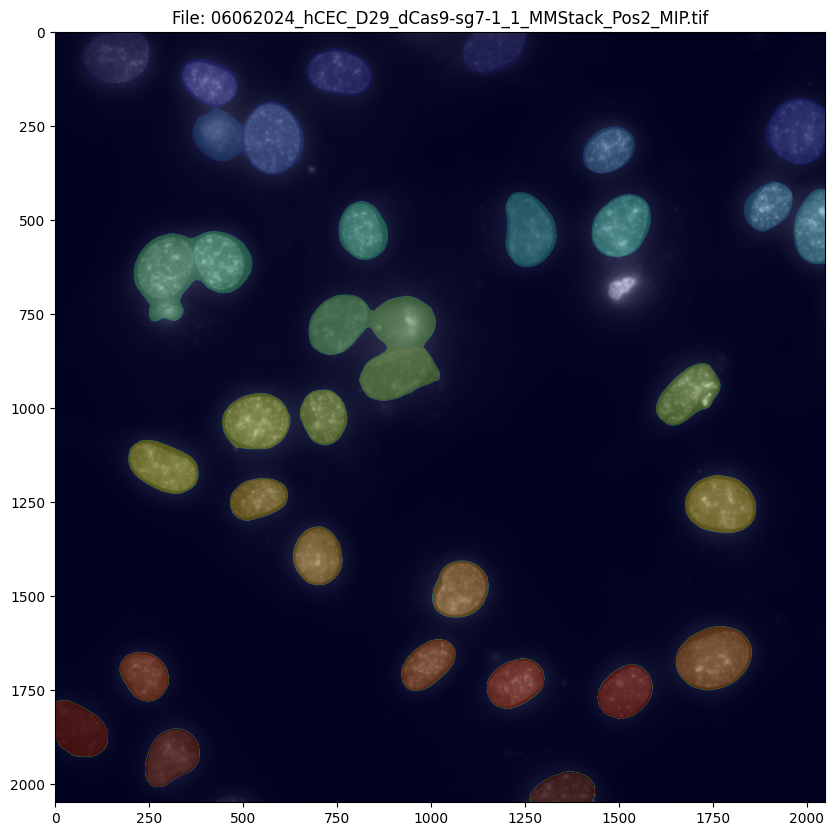

In [9]:
# Overlay the corresponding mask on a channel (given as c) of a given image
# to visually inspect

# Specify the index of the image to check
# and the channel to plot — remember CH1 for ImageJ but channel 0 for Python!
image_index = 4 # Replace with the desired index
c = 0 # remember the channel order in these images

# Find the corresponding mask index
# and define the image and mask pair
mask_index = [pair[1] for pair in matched_indices if pair[0] == image_index][0]

my_image = all_images['image'][image_index]
image_file = file_names['image'][image_index]
my_mask_n = all_images['mask_n'][mask_index]

# Select the c channel
channel_image = my_image[c, ...]

# Overlay the mask on the rest of the image if they have the same dimensions
if channel_image.shape != my_mask_n.shape:
    print("Warning: The image and mask sizes do not match. Please check your data.")
else:
    overlay = np.ma.masked_where(my_mask_n == 0, my_mask_n)
    plt.figure(figsize=(10, 10))
    plt.imshow(channel_image, cmap='gray')  # Display the selected channel in grayscale
    plt.imshow(my_mask_n, cmap='jet', alpha=0.25)  # Overlay the mask with transparency
    plt.title(f'File: {image_file}')
    #plt.axis('off')  # Turn off axis labels
    plt.show()

In [11]:
# CHUNK 3 #

# Extract a set of metrics for each ROI defined by the mask from the corresponding image
# using the measureROIs() function, which does background subtraction

# Use concurrent processing to handle images
if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=4) as executor:
        # Prepare data for processing
        tasks = [(img_index, all_images['image'][img_index], all_images['mask_n'][mask_index]) 
                 for img_index, mask_index in matched_indices]
        # Process data in parallel
        results = list(executor.map(measureROIs, tasks))

        all_roi_metrics = {f'Image {img_index}': roi_metrics for img_index, roi_metrics in results}

    logging.info("Metrics extraction with background subtraction complete for all ROIs across all matched images.")

# Now, all_roi_metrics contains the metrics for each ROI in each channel for each matched image

2024-08-08 11:09:39,063 - INFO - Metrics extraction with background subtraction complete for all ROIs across all matched images.


In [13]:
# Extract a set of metrics for each ROI defined by the mask from the corresponding image
# without doing background subtraction

# Create a dictionary to store metrics for each image
nobs_roi_metrics = {}

# Loop over the matched indices to define the image and mask to utilize
for img_index, mask_index in matched_indices:
    my_image = all_images['image'][img_index]
    my_mask_n = all_images['mask_n'][mask_index]

    # Extract the ID for each of the ROIs — which is their assigned gray level > 0 (0 being the background)
    my_rois = np.unique(my_mask_n)
    my_rois = my_rois[my_rois != 0]
    
    # Dictionary to store metrics for each ROI in each channel of this image
    roi_metrics = {}

    # Iterate over each ROI
    for roi in my_rois:
        roi_metrics[roi] = {}

        # Calculate area of the ROI
        area = np.sum(my_mask_n == roi)
        
        # Iterate over each channel
        for channel_index in range(my_image.shape[0]):
            # Isolate the ROI in this channel
            roi_pixels = my_image[channel_index, my_mask_n == roi]

            # Check if roi_pixels is empty
            if roi_pixels.size == 0:
                print(f"ROI {roi} in Image {img_index}, Channel {channel_index} is empty.")
                continue
                
            # Calculate metrics
            mean_intensity = np.mean(roi_pixels)
            median_intensity = np.median(roi_pixels)
            std_deviation = np.std(roi_pixels)
            max_value = np.max(roi_pixels)
            min_value = np.min(roi_pixels)
            
            # Store metrics
            roi_metrics[roi][f'Channel {channel_index}'] = {
                'area': area,
                'avg': mean_intensity,
                'median': median_intensity,
                'std': std_deviation,
                'maxima': max_value,
                'minima': min_value
            }

    # Store the metrics for this image
    nobs_roi_metrics[f'Image {img_index}'] = roi_metrics

# Now, nobs_roi_metrics contains the metrics for each ROI in each channel for each matched image, 
# without background subraction

In [15]:
# CHUNK 4 #

# Turn the all_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in all_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(data_rows)

In [17]:
# CHUNK 4.2 #

# Turn the nobs_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in nobs_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
metrics_nobs_df = pd.DataFrame(data_rows)

In [23]:
# Display the first few rows of the DataFrame to verify it's correct
print(metrics_df.head())

   image_index                                           filename  \
0            0  06062024_hCEC_D29_dCas9-sgNC_1_MMStack_Pos3_MI...   
1            0  06062024_hCEC_D29_dCas9-sgNC_1_MMStack_Pos3_MI...   
2            0  06062024_hCEC_D29_dCas9-sgNC_1_MMStack_Pos3_MI...   
3            0  06062024_hCEC_D29_dCas9-sgNC_1_MMStack_Pos3_MI...   
4            0  06062024_hCEC_D29_dCas9-sgNC_1_MMStack_Pos3_MI...   

                  experiment  ROI_index  channel   area           avg  \
0  06062024_hCEC_D29_pre-seq          1        0  20947  11347.075852   
1  06062024_hCEC_D29_pre-seq          1        1  20947   -215.294745   
2  06062024_hCEC_D29_pre-seq          2        0  37615  11197.244514   
3  06062024_hCEC_D29_pre-seq          2        1  37615   1858.503166   
4  06062024_hCEC_D29_pre-seq          3        0  15562   7513.583292   

         median          std        maxima       minima  
0  12067.778769  4065.027500  25343.778769  3347.778769  
1   -219.645631    31.122120  

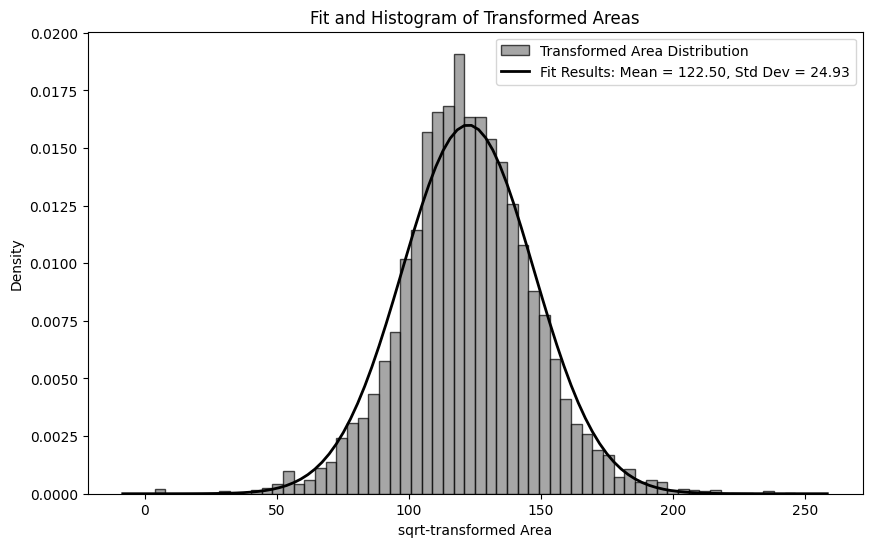

In [25]:
# Plot the distribution of ROI areas in the raw data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_original.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [27]:
# CHUNK 5 # 

# Remove values outside the number of SD that the user defines 
# for the log or sqrt-transformed data, as above
# (2*SD seems generally reasonable for this data)
# using the outliersOut function found in outliers_removal.py
sd_cutoff = 2
tx = "sqrt"

filtr_metrics_df, thresholds = outliersOut(metrics_df, sd_filter = sd_cutoff, transformation = tx)

# Print the thresholds to verify them
print("Calculated thresholds:")
print(f"Mean: {thresholds[0]}, Std Dev: {thresholds[1]}")
print(f"Lower Threshold: {thresholds[2]}, Upper Threshold: {thresholds[3]}")

# Optionally, display some of the filtered data to inspect the results
# print(filtr_metrics_df.head())

Calculated thresholds:
Mean: 122.50419235896311, Std Dev: 24.928317228865346
Lower Threshold: 72.64755790123242, Upper Threshold: 172.36082681669382


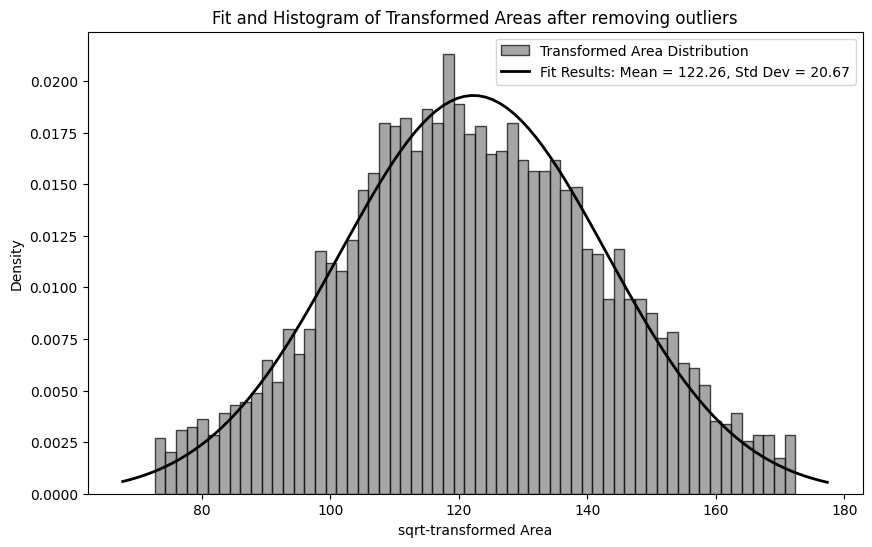

In [29]:
# Plot the distribution of ROI areas in the filtered data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = filtr_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas after removing outliers')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_no-outliers.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [ ]:
# Replace these with the indices of the image, ROI, and channel you want to inspect
image_index = 5  # First image
roi_index = 9   # ROI with ID 9
channel_index = 0  # First channel

image_file = image_file_names[image_index]
image_key = f"Image {image_index}"
roi_metrics = all_roi_metrics.get(image_key, {})
roi_channel_metrics = roi_metrics.get(roi_index, {}).get(f'Channel {channel_index}', {})

print(f"Metrics for Image {image_index}, ({image_file}), ROI {roi_index}, Channel {channel_index}:")
for metric, value in roi_channel_metrics.items():
    print(f"  {metric}: {value:.2f}")

/Users/nestor/anaconda3/envs/python-genv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


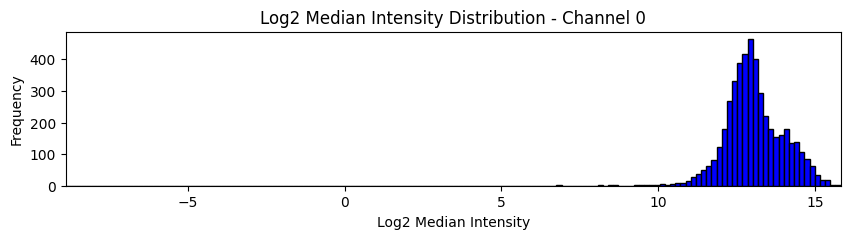

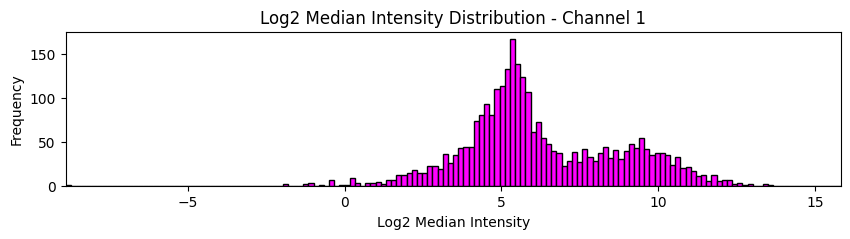

In [37]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Transform the metric values to log2
metrics_df['log2_median'] = np.log2(metrics_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metrics_df['log2_median'].min()
global_max_intensity = metrics_df['log2_median'].max()
max_frequency = metrics_df.groupby('channel')[my_metric].count().max()

# Define channel colors
# channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}
channel_colors = {0: 'blue', 1: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in metrics_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize = (10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins = 150, 
                               color = channel_colors.get(channel, 'gray'), 
                               edgecolor = 'black', 
                               linewidth = 1, 
                               #density = True, 
                               range = (global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    #plt.ylim(0, max_frequency)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()

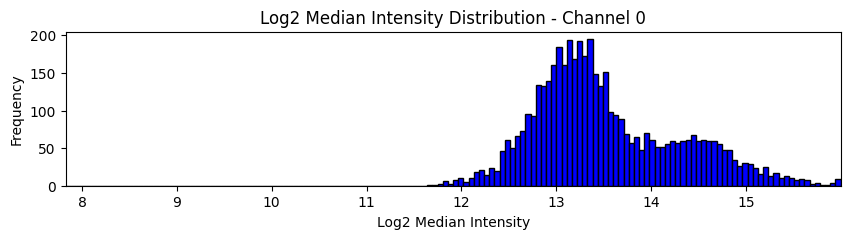

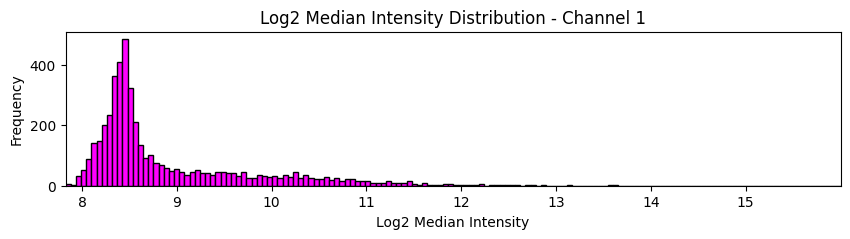

In [41]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Transform the metric values to log2
metrics_nobs_df['log2_median'] = np.log2(metrics_nobs_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metrics_nobs_df['log2_median'].min()
global_max_intensity = metrics_nobs_df['log2_median'].max()
max_frequency = metrics_nobs_df.groupby('channel')[my_metric].count().max()

# Define channel colors
# channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}
channel_colors = {0: 'blue', 1: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in metrics_nobs_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize = (10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins = 150, 
                               color = channel_colors.get(channel, 'gray'), 
                               edgecolor = 'black', 
                               linewidth = 1, 
                               #density = True, 
                               range = (global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    #plt.ylim(0, max_frequency)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()

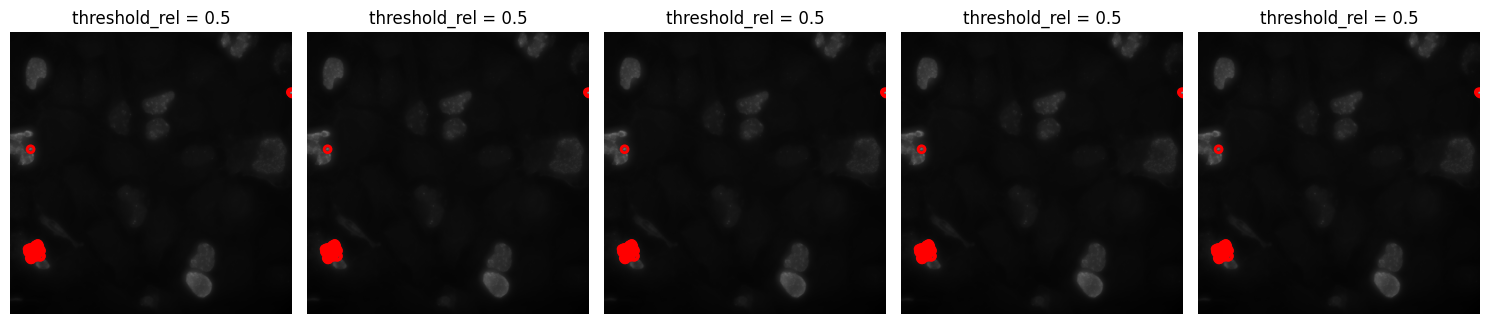

In [114]:
# Test different parameter values

# Parameters to test
my_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Adjust with your values

# Select channel 2 for testing
channel = 1
image = my_image[channel]

# Number of subplots needed (one for each value in min_sigma_values)
num_subplots = len(my_values)

# Set up a large enough figure to hold all subplots
plt.figure(figsize=(15, 3 * num_subplots))

# Loop over each min_sigma value and perform blob detection
for idx, threshold_rep in enumerate(my_values):
    # Detect blobs
    blobs_log = feature.blob_log(image.astype(float), min_sigma=0.05, max_sigma=5, num_sigma=10, threshold_rel=threshold_rel)

    # Create a subplot for each min_sigma value
    plt.subplot(1, num_subplots, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'threshold_rel = {threshold_rel}')

    # Plot the blobs
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r*500, color='red', linewidth=2, fill=False)
        plt.gca().add_patch(c)

    plt.axis('off')

plt.tight_layout()
plt.show()

In [160]:
# Find spots in FISH channel

# Make a dictionary to store blob information per ROI
blobs_per_roi = {}

# fish_params: min_sigma = 0.05, max_sigma = 5, num_sigma = 10, threshold_rel = 0.3

# Iterate over each channel in 'my_image'
# looking for blobs
for channel_index in range(my_image.shape[0]):
    image = my_image[channel_index]

    # Detect blobs using Laplacian of Gaussian
    # Adjust these parameters as necessary for your data
    blobs_log = feature.blob_log(image.astype(float), 
                                 min_sigma = 0.05, 
                                 max_sigma = 5, 
                                 num_sigma = 10, 
                                 threshold_rel = 0.3)

    # Filter detected blobs to be within ROIs defined in my_nucmask
    for blob in blobs_log:
        y, x, r = blob  # Blob position and estimated radius
        roi_id = my_nucmask[int(y), int(x)]
        if roi_id != 0:  # Check if inside an ROI
            if roi_id not in blobs_per_roi:
                blobs_per_roi[roi_id] = []
            blobs_per_roi[roi_id].append((channel_index, x, y, r))



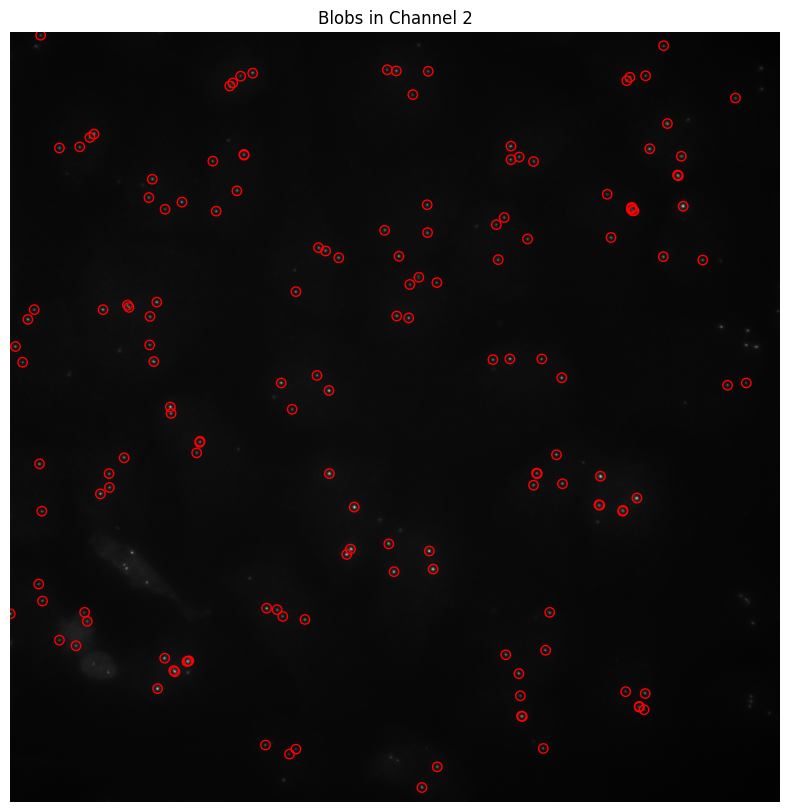

In [161]:
# Visualize the result of FISH spot detection

# Select a channel to visualize, e.g., the first channel
selected_channel = 2
plt.figure(figsize=(10, 10))
plt.imshow(my_image[selected_channel], cmap='gray')

# Plot the blobs
for blob_info in blobs_per_roi.values():
    for blob in blob_info:
        channel, x, y, r = blob
        if channel == selected_channel:  # Only plot blobs for the selected channel
            c = plt.Circle((x, y), r*250, color='red', linewidth = 1, fill = False)
            plt.gca().add_patch(c)
            
plt.title(f'Blobs in Channel {selected_channel}')
plt.axis('off')
plt.show()

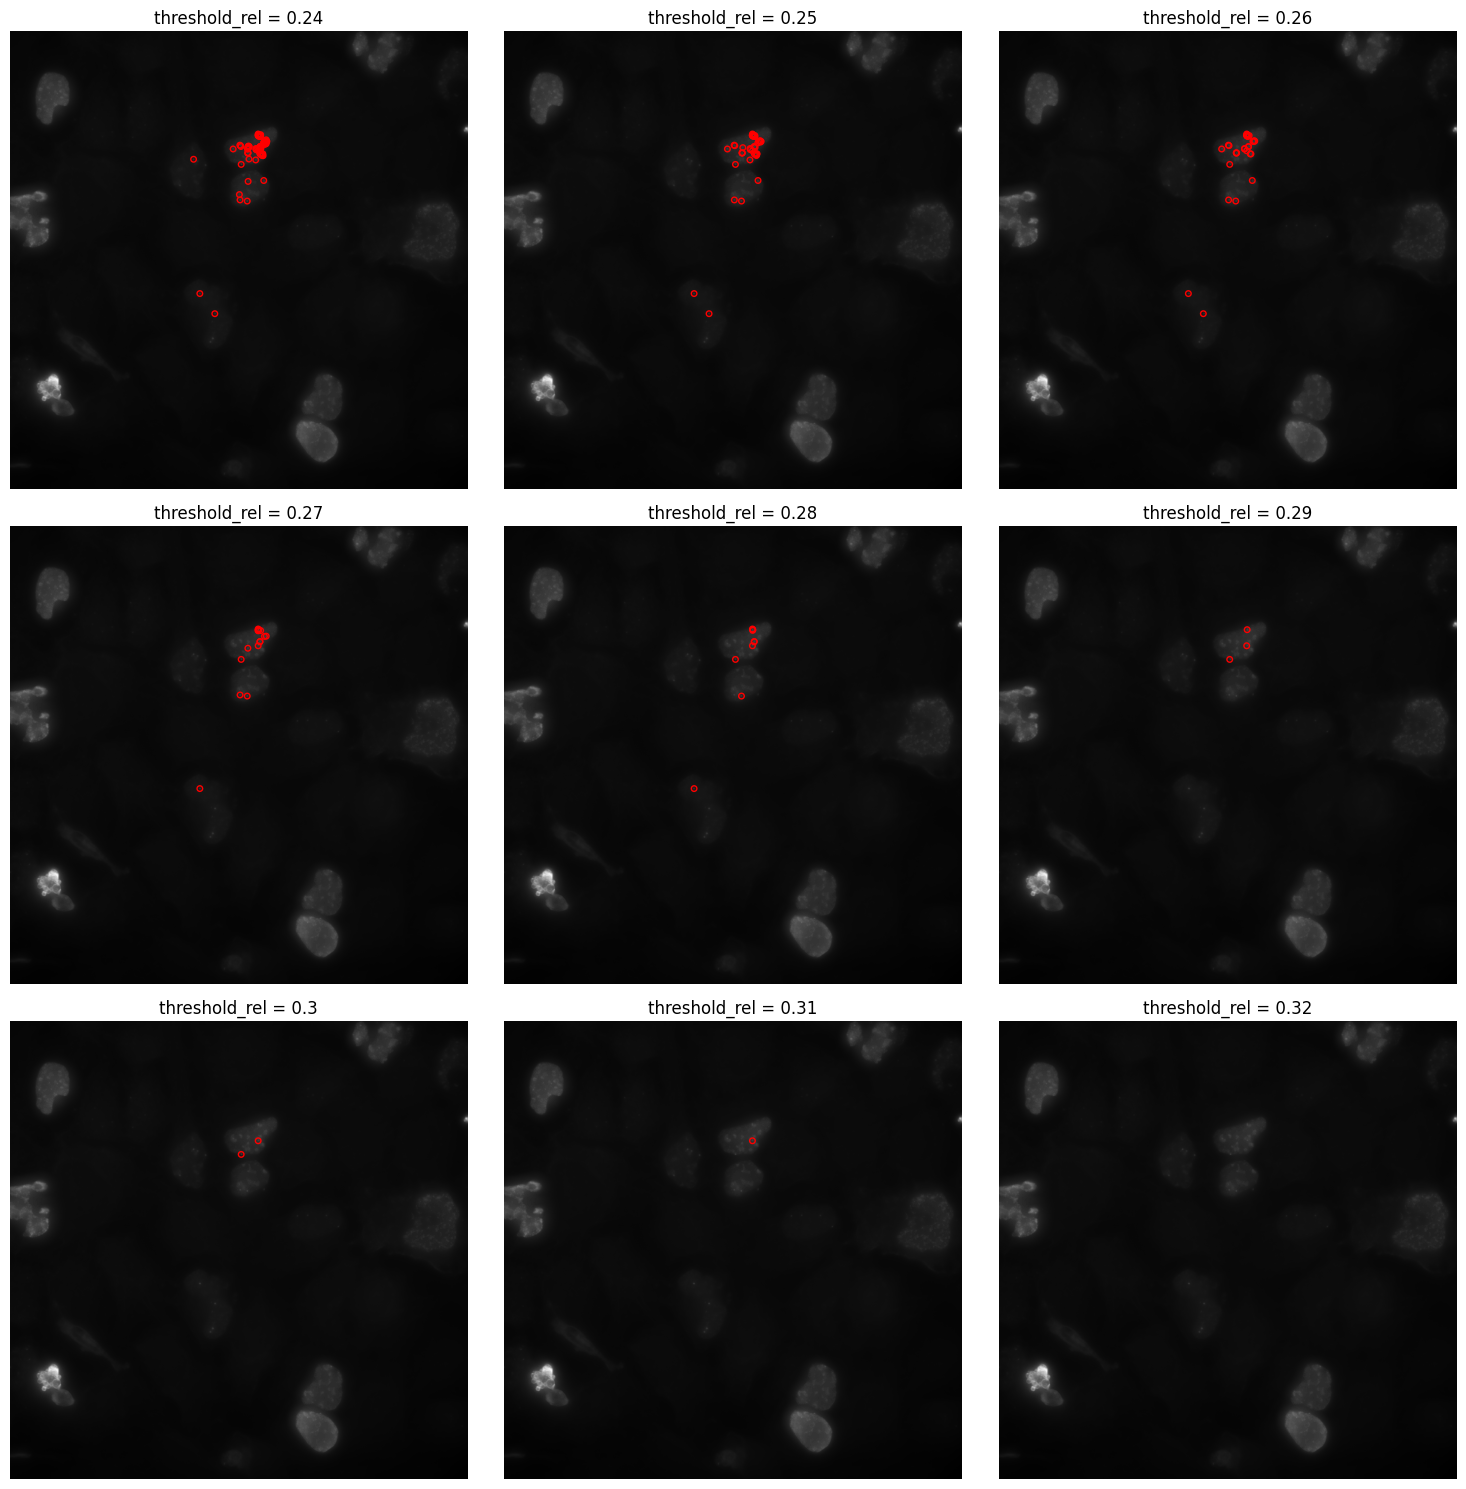

In [176]:
# Try to find spots in IF channel using same parameters as for FISH channel (chunk above)

# Specified ROIs to focus on
selected_rois = [9, 10, 11, 14, 16, 17, 20, 26, 29]

# Parameters for blob detection (these work well for FISH, channel 2)
# min_sigma = 0.05
# max_sigma = 5
# num_sigma = 10
# threshold_rel = 0.3

# Parameters for blob detection (adjust these for channel 1)
min_sigma = 0.05
max_sigma = 5
num_sigma = 10

# Parameters to test
threshold_values = [0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32] # adjust as needed

# Set up a figure for subplots
n_cols = 3
n_rows = -(-len(threshold_values) // n_cols)  # Ceiling division to get number of rows
plt.figure(figsize=(15, 5 * n_rows))  # Adjust the size as needed

# Select channel 1 for blob detection
channel_index = 1
image = my_image[channel_index]

# Dictionary to store blob information for each ROI
blobs_per_roi = {}

# Iterate over each threshold_rel value
for i, threshold_rel in enumerate(threshold_values):
    # Detect blobs using Laplacian of Gaussian for the entire image
    blobs_log = feature.blob_log(image.astype(float), 
                                 min_sigma=min_sigma, 
                                 max_sigma=max_sigma, 
                                 num_sigma=num_sigma, 
                                 threshold_rel=threshold_rel)

    # Create a subplot for each threshold_rel value
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image, cmap='gray')

    # Filter and plot blobs for selected ROIs
    for blob in blobs_log:
        y, x, r = blob
        roi_id = my_nucmask[int(y), int(x)]
        if roi_id in selected_rois:
            c = plt.Circle((x, y), r*250, color='red', linewidth=1, fill=False)
            plt.gca().add_patch(c)

    plt.title(f'threshold_rel = {threshold_rel}')
    plt.axis('off')

plt.tight_layout()
plt.show()

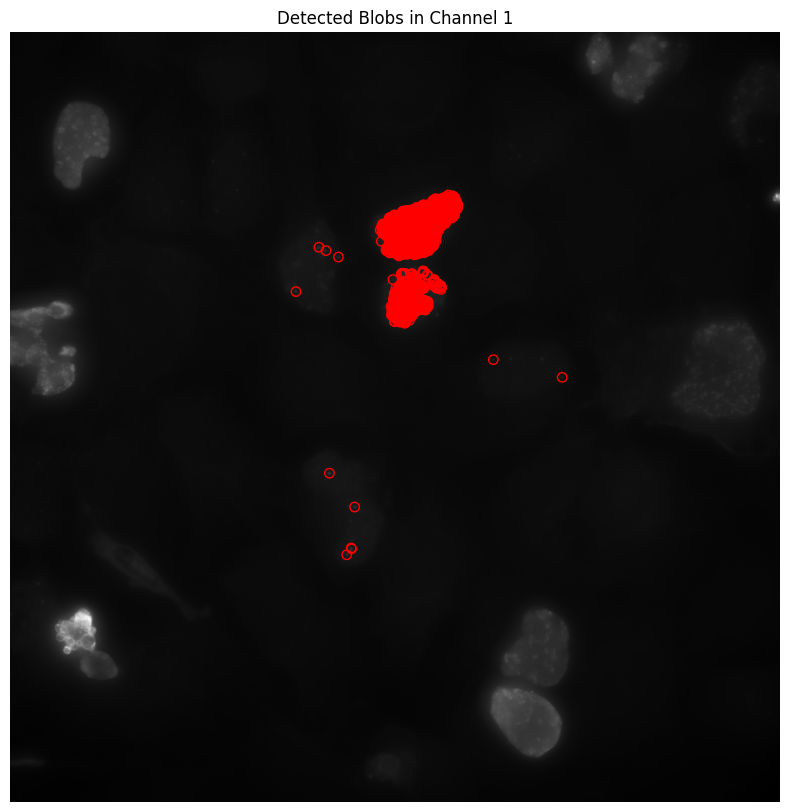

In [188]:
# Assuming 'my_image' and 'my_nucmask' are defined
channel = 1
image = my_image[channel]

# Specified ROIs to focus on
selected_rois = [9, 10, 11, 14, 16, 17, 20, 26, 29]

# Parameters for blob detection (adjust these for channel 1)
min_sigma = 0.05
max_sigma = 5
num_sigma = 10

# After testing with the script in the previous chunk, 
# I find that the following threshold_rel values are best for the given mean intensities
known_intensities = [900, 1200, 1500, 2200, 2800]
known_thresholds = [0.096, 0.125, 0.19, 0.24, 0.285]

# Fit a quadratic polynomial (degree 2) to known data
coefficients = np.polyfit(known_intensities, known_thresholds, 2)
polynomial = np.poly1d(coefficients)

# Make a dictionary to store blob information per ROI
blobs_per_roi = {}

# Detect blobs using Laplacian of Gaussian for the entire image
threshold_rel_avg = np.mean([polynomial(np.mean(image[my_nucmask == roi_id])) for roi_id in selected_rois])
blobs_log = feature.blob_log(image.astype(float), 
                             min_sigma = min_sigma, 
                             max_sigma = max_sigma, 
                             num_sigma = num_sigma, 
                             threshold_rel=threshold_rel_avg)

# Filter detected blobs to be within the selected ROIs
for blob in blobs_log:
    y, x, r = blob
    roi_id = my_nucmask[int(y), int(x)]
    if roi_id in selected_rois:
        if roi_id not in blobs_per_roi:
            blobs_per_roi[roi_id] = []
        blobs_per_roi[roi_id].append((x, y, r))

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for roi_id, blobs in blobs_per_roi.items():
    for x, y, r in blobs:
        c = plt.Circle((x, y), r * 250, color='red', linewidth=1, fill=False)
        plt.gca().add_patch(c)
plt.axis('off')
plt.title('Detected Blobs in Channel 1')
plt.show()